In [1]:
from z3 import *
from utils import *
from cardinality_constraints import *
from pseudoboolean_constraints import * 
from logical_relation_constraints import *
import time
import json

We define an auxiliar function in order to read the instance file

In [2]:
def read_instance(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        instance = {}
        instance["m"] = int(lines[0].strip())
        instance["n"] = int(lines[1].strip())
        instance["l"] = [int(x) for x in lines[2].strip().split()]
        instance["s"] = [int(x) for x in lines[3].strip().split()]
        instance["D"] = []

        for line in lines[4:]:
            distances = [int(x) for x in line.split()]
            instance["D"].append(distances)

        return instance

We read the first instance

In [3]:
path = '/Users/alessiopittiglio/projects/cdmo_project'
file_path = "/Instances/inst07.dat"
instance = read_instance(path + file_path)

In [4]:
import pprint
# pprint.pp(instance)

In [5]:
def vehicle_routing_sat(m, n, s, l, D, symmetry_breaking = False, implied_constraint = False, search='Binary', timeout_duration = None, is_dimacs = False):
    # n: number of items
    # m: number of couriers
    # l: load capacities of couriers
    # s: sizes of items
    # D: distance matrix between points (including the origin)

    start_time = time.time()

    x = [[Bool(f"x_{i}_{j}") for j in range(n)] for i in range(m)]  # x[i, j]: courier i delivers item j
    y = [[[Bool(f"y_{i}_{j}_{k}") for k in range(n + 1)] for j in range(n + 1)] for i in range(m)]  # y[i, j, k]: courier i travels from j to k
    seq = [[Bool(f"seq_{i}_{j}") for j in range(n)] for i in range(n)]  # seq[i][j]: item i is in position j in the sequence
    
    solver = Solver()
    
    s_bin = [num_to_bits(ld_int(sj), sj)[::-1] for sj in s]
    l_bin = [num_to_bits(ld_int(li), li)[::-1] for li in l]

    # Constraints
    # 1. Each item must be assigned to exactly one courier
    for j in range(n):
        solver.add(exactly_one([x[i][j] for i in range(m)], f"assign_item_{j}"))

    # 2. Load capacity constraints for each courier
    for i in range(m):
        solver.add(Pb_seq_counter([x[i][j] for j in range(n)], s, l[i], f"load_courier_{i}"))
        # solver.add(Pb_adder_networks([x[i][j] for j in range(n)], s, l[i]))

    # 3. Route constraints: each courier's route must start and end at the origin
    for i in range(m):
        # Start at the origin
        solver.add(exactly_one([y[i][n][k] for k in range(n)], f"start_{i}"))
        # End at the origin
        solver.add(exactly_one([y[i][k][n] for k in range(n)], f"end_{i}"))

        for j in range(n):
            # If a courier visits an item, it must leave that item
            solver.add(Implies(x[i][j], exactly_one([y[i][j][k] for k in range(n + 1)], f"visit_{i}_{j}")))
            # If a courier arrives at an item, it must leave from that item
            solver.add(Implies(x[i][j], exactly_one([y[i][k][j] for k in range(n + 1)], f"arrive_{i}_{j}")))

            # If y[i][j] is false, all y[i][j][k] must be false
            solver.add(And([Or(x[i][j], Not(y[i][j][k])) for k in range(n + 1)]))
            solver.add(And([Or(x[i][j], Not(y[i][k][j])) for k in range(n + 1)]))

    # 4. Preventing sub-tours within each courier's route
    for i in range(n):
        solver.add(exactly_one(seq[i], f"position_{i}"))

    for i in range(m):
        for j in range(n):
            for k in range(n):
                solver.add(Implies(y[i][j][k], successor(seq[j], seq[k])))
            solver.add(Implies(y[i][n][j], seq[j][0]))

    # Symmetry breaking constraints
    if symmetry_breaking:
        w = [[Bool(f"w_{i}_{k}") for k in range(ld_int(sum(s)))] for i in range(m)]

        sorted_loads = [(l[i], i) for i in range(m)]
        sorted_loads.sort(reverse = True)
        l, permutation = zip(*sorted_loads)
        l = list(l)
        permutation = list(permutation)
        
        solver.add([lex_less_equal(w[i+1], w[i]) for i in range(len(w) - 1)])

        for i in range(m - 1):
            solver.add(Implies(same_load_constraint(w[i], w[i + 1]), lex_less_equal(x[i], x[i + 1])))
            
        for i in range(m):
            solver.add(conditional_sum_K_bin(x[i], s_bin, w[i], f"courier_load_{i}"))
            solver.add(lex_less_equal(w[i], l_bin[i]))

    # Additional implied constraints
    if implied_constraint:
        for i in range(m):
            solver.add(at_least_one(x[i]))

        # Ensure no single-node loops
        for i in range(m):
            for j in range(n):
                solver.add(Not(y[i][j][j]))
        
    # Define the distance traveled by any courier
    flattened_y = [[y[i][j][k] for j in range(n + 1) for k in range(n + 1)] for i in range(m)]
    flattened_D = [D[i][j] for i in range(n + 1) for j in range(n + 1)]

    upper_bound = sum(max(row) for row in D)

    if implied_constraint:
        max_distances = [max(D[i][:-1]) for i in range(n)]
        max_distances.sort()
        upper_bound = sum(max_distances[m:]) + max(D[n]) + max([D[j][n] for j in range(n)])
    lower_bound = max([D[n][j] + D[j][n] for j in range(n)])

    if is_dimacs:
        var_map = output_to_dimacs(solver)
        var_map_filename = os.path.join(os.getcwd(), 'variable_map.json')
        with open(var_map_filename, 'w') as f:
            f.write(json.dumps(var_map))

    encoding_time = time.time()
    print(f"Encoding finished at time {round(encoding_time - start_time, 1)}s, now start solving/optimization search")
    timeout = encoding_time + (timeout_duration / 1000)

    # Binary search for minimizing the maximum distance
    low = lower_bound
    high = upper_bound # Initial upper bound

    best_solution = None
    best_max_distance = None

    while low <= high:
        mid = (low + high) // 2
        solver.push()

        # Add the current distance constraint
        for i in range(m):
            solver.add(PbLe([(lit, flattened_D[idx]) for idx, lit in enumerate(flattened_y[i])], mid))
            # solver.add(Pb_adder_networks(flattened_y[i], flattened_D, mid))
            # solver.add(Pb_seq_counter(flattened_y[i], flattened_D, mid, f"distance_courier_{i}"))

        now = time.time()
        if now >= timeout:
            break
        solver.set('timeout', millisecs_left(now, timeout)) 

        if solver.check() == sat:
            best_solution = solver.model()
            best_max_distance = obj_function(best_solution, m, D, y)
            high = mid - 1
        else:
            low = mid + 1
        
        solver.pop()
    
    if best_solution:
        if symmetry_breaking:
            x_copy = copy.deepcopy(x)
            y_copy = copy.deepcopy(y)
            for i in range(m):
                x[permutation[i]] = x_copy[i]
                y[permutation[i]] = y_copy[i]
            
        routes = []
        print(best_max_distance)
        for i in range(m):
            items = [j for j in range(n) if is_true(best_solution.evaluate(x[i][j]))]
            print(f"Courier {i + 1} delivers items: {items}")
            load = [s[i] for i in items]
            print(f"Carico: ", sum(load))
            route = []
            for j in range(n + 1):
                for k in range(n + 1):
                    if is_true(best_solution.evaluate(y[i][j][k])):
                        route.append((j, k))
            routes.append(route)
            print(f"Route of courier {i + 1}: {route}")
        return routes
    else:
        return print('unsat')
    pass

Encoding finished at time 64.0s, now start solving/optimization search
170
Courier 1 delivers items: [4, 7, 14, 16]
Carico:  35
Route of courier 1: [(4, 14), (7, 16), (14, 17), (16, 4), (17, 7)]
Courier 2 delivers items: [1]
Carico:  11
Route of courier 2: [(1, 17), (17, 1)]
Courier 3 delivers items: [2, 6, 12]
Carico:  49
Route of courier 3: [(2, 12), (6, 2), (12, 17), (17, 6)]
Courier 4 delivers items: [3, 10, 11, 13]
Carico:  61
Route of courier 4: [(3, 11), (10, 13), (11, 17), (13, 3), (17, 10)]
Courier 5 delivers items: [8, 9, 15]
Carico:  51
Route of courier 5: [(8, 17), (9, 8), (15, 9), (17, 15)]
Courier 6 delivers items: [0, 5]
Carico:  12
Route of courier 6: [(0, 5), (5, 17), (17, 0)]


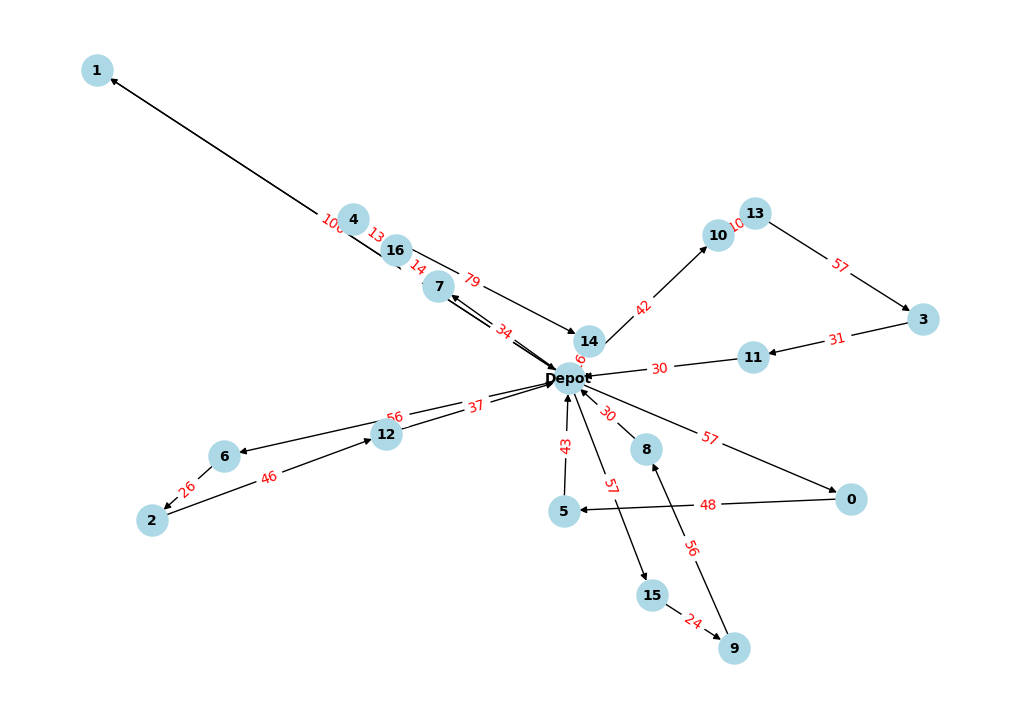

CPU times: user 6min 2s, sys: 301 ms, total: 6min 2s
Wall time: 6min 4s


In [6]:
%%time
display_routing(vehicle_routing_sat(instance["m"], instance["n"], instance["s"], instance["l"], instance["D"], symmetry_breaking = False, implied_constraint = False, timeout_duration=1000*60*5, is_dimacs = True), D = instance["D"])

# DIMACS

Functionality of this module is available only if the PyPBLib package is installed, e.g. from PyPI

`pip install pypblib`

- best       = 0
- bdd        = 1
- seqcounter = 2
- sortnetwrk = 3
- adder      = 4
- binmerge   = 5
- native     = 6

In [19]:
!pip install pypblib

Defaulting to user installation because normal site-packages is not writeable
  Using cached pypblib-0.0.4.tar.gz (74 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pypblib: filename=pypblib-0.0.4-cp39-cp39-macosx_10_9_universal2.whl size=365415 sha256=37707df4c480286ee3337b7f13c99f09b038f407004c3e88de91baacf5e61bb5
  Stored in directory: /Users/alessiopittiglio/Library/Caches/pip/wheels/8e/ea/8b/e642f36ca04ed40c026cbeb241b53f190489edc12511437f89
Successfully built pypblib

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [30]:
import itertools
from pysat.pb import *
from pysat.formula import CNF
from pysat.solvers import Glucose42

with open('variable_map.json', 'r') as f:
    variable_mapping = json.load(f)

D = instance["D"]
m = instance["m"]
n = instance["n"]

flattened_D = list(itertools.chain(*D))
upper_bound = sum(max(row) for row in D)

# Determine the starting value for new variables
max_variable_value = max(variable_mapping.values())
next_variable_value = max_variable_value + 1

flattened_y = [[] for _ in range(m)]
for i in range(m):
    for j in range(n+1):
        for k in range(n+1):
            if j == n and k == n:
                flattened_y[i].append(next_variable_value)
                next_variable_value += 1
            else:
                flattened_y[i].append(variable_mapping[f"y_{i}_{j}_{k}"])

cnf_file = "problem.cnf"
formula = CNF(from_file=cnf_file)
solver = Glucose42(use_timer = True)
solver.append_formula(formula)
sat = solver.solve()

# Optimization
best_solution = None
best_cost = upper_bound

for cost in range(upper_bound, -1, -1):
    # Add constraint to limit the maximum covered distance
    added_constraints = []
    for i in range(m):
        cnf = PBEnc.leq(lits=flattened_y[i], weights=flattened_D, bound=cost, encoding=0)
        added_constraints.extend(cnf.clauses)
        for c in cnf.clauses:
            solver.add_clause(c)

    if solver.solve():
        best_solution = solver.get_model()
        best_cost = cost
        break
    else:
        # Remove the constraints added in this iteration
        for c in added_constraints:
            solver.add_clause([-lit for lit in c])

print("Best cost:", best_cost)

solver.delete()

Best cost: 44


In [25]:
cnf_file = "problem.cnf"
formula = CNF(from_file=cnf_file)
solver = Glucose42(use_timer=True)
solver.append_formula(formula)
sat = solver.solve()

# Optimization
best_solution = None
best_cost = upper_bound

for cost in range(upper_bound, -1, -1):
    assumptions = []
    for i in range(m):
        cnf = PBEnc.leq(lits=flattened_y[i], weights=flattened_D, bound=cost, encoding=0)
        for clause in cnf.clauses:
            assumptions.extend(clause)

        assumptions = list(set(assumptions))
    
    if solver.solve(assumptions=assumptions):
        print('Solution found for cost:', cost)
        best_solution = solver.get_model()
        best_cost = cost
        break

if best_solution:
    print("Best solution:", best_solution)
else:
    print("No solution found")

solver.delete()

No solution found
